# 1. Понимание бизнеса

## 1.1. Цель

Предсказать качество вина

## 1.2. Описание

Набор данных был загружен из репозитория машинного обучения UCI.

Эти два набора данных относятся к красному и белому вариантам португальского вина "Винью Верде". Ссылка [Cortez et al., 2009]. Из-за проблем с конфиденциальностью и логистики доступны только физико-химические (исходные) и сенсорные (выходные) переменные (например, нет данных о сортах винограда, марке вина, цене продажи вина и т. Д.).

Эти наборы данных можно рассматривать как задачи классификации или регрессии. Классы упорядочены и не сбалансированы (например, нормальных вин едят больше, чем отличных или плохих). Алгоритмы обнаружения выбросов могут использоваться для обнаружения нескольких отличных или плохих вин. Кроме того, мы не уверены, все ли входные переменные актуальны. Так что было бы интересно протестировать методы выбора функций.

Два набора данных были объединены, и несколько значений были удалены случайным образом

# 2. Data Understanding

## 2.1. Import Libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV

# Metrics
from sklearn.metrics import r2_score

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2. Вспомогательные функции 

In [2]:
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    _ = sns.heatmap(
        corr, 
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()
    
def plot_variable_importance( X , y ):
    tree = DecisionTreeRegressor( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

## 2.3. Выгрузка данных

In [3]:
wines = pd.read_csv('winequalityN.csv')
print('Dataset: ', wines.shape)

Dataset:  (6497, 13)


## 2.4. Статистика и визуализация

In [4]:
wines.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### 2.4.1. Описание переменных:

* *type* - категория вина: красное (red) или белое (white) 
* *fixed acidity* - фиксированная кислотность
* *volatile acidity* - летучая кислотность
* *citric acid* - лимонная кислота
* *residual sugar* - остаточный сахар
* *chlorides* - хлориды
* *free sulfur dioxide* - свободный диоксид серы
* *total sulfur dioxide* - диоксид серы общий
* *density* - плотность
* *pH* - уровень кислотности(pH)
* *sulphates* - сульфаты
* *alcohol* - алкоголь
* *quality* - качество (оценка от 0 до 10)

### 2.4.2 Ключевая информация о переменных

In [5]:
wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [6]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null object
fixed acidity           6487 non-null float64
volatile acidity        6489 non-null float64
citric acid             6494 non-null float64
residual sugar          6495 non-null float64
chlorides               6495 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6488 non-null float64
sulphates               6493 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 659.9+ KB


### 2.4.3. Тепловая карта корреляции

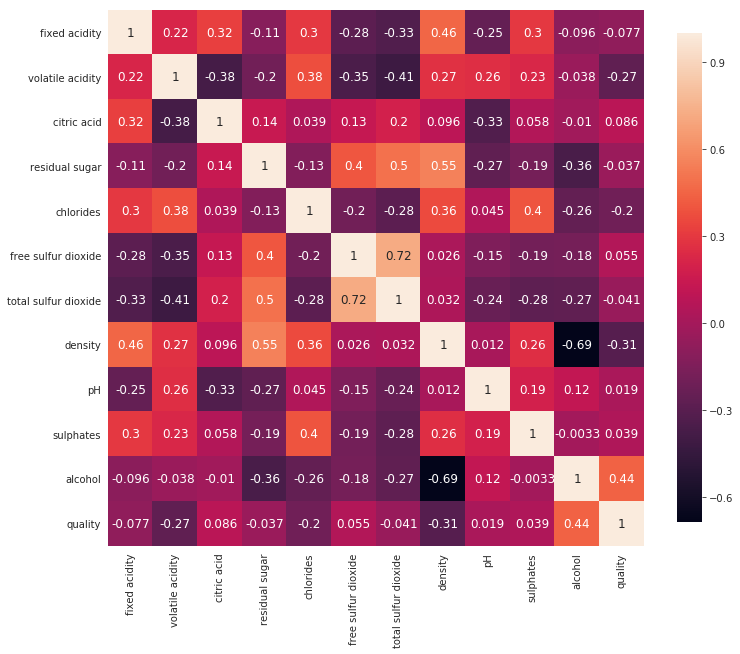

In [7]:
plot_correlation_map(wines)

### 2.4.4 Взаимосвязь между переменными 

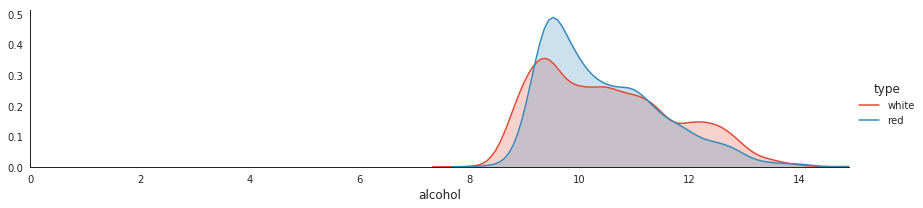

In [8]:
plot_distribution( wines , var = 'alcohol' , target = 'type' )

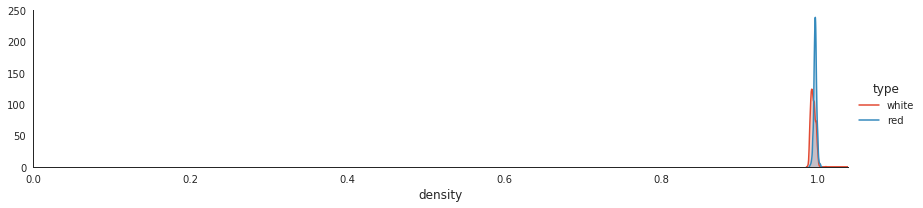

In [9]:
plot_distribution( wines , var = 'density' , target = 'type')

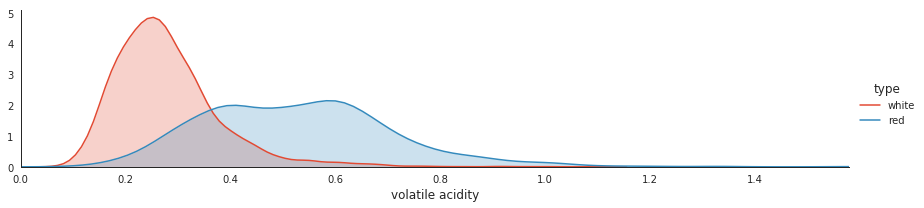

In [10]:
plot_distribution( wines , var = 'volatile acidity' , target = 'type')

### 2.4.5. Категория вина 

/home/sergmath/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


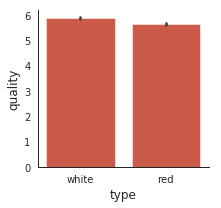

In [11]:
plot_categories( wines , cat = 'type' , target = 'quality' )

### 2.4.6. Обучающая и тестовая выборки 

Для построения и валидации моделей разобъем всю выборку на train- и test-подвыборки. Разбиение будем проводить случайным образом. Соотношение train и test: 70:30.

In [12]:
wines['subset'] = np.random.choice(['train', 'test'], size = wines.shape[0], p = [.7, .3])
wines.subset.value_counts()

train    4582
test     1915
Name: subset, dtype: int64

# 3. Data preparation

## 3.1. Преобразуем категориальные переменные в числовые

In [13]:
wines['white_wine'] = np.where(wines.type == 'white', 1, 0)

## 3.2. Заполним пропущенные значения

Пропущенные значения заполняем как средние значения по соответствующей категории вина.

In [14]:
# Средние значения
avg_values = wines[wines.subset == 'train'].groupby('type').mean().to_dict()

# Фичи, имеющие пропущенные значения
na_features_list = [
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'residual sugar',
    'chlorides',
    'pH',
    'sulphates' 
]

for feature in na_features_list:
    wines[feature + '_all'] = wines.apply(lambda x: avg_values.get(feature).get(x.type) if np.isnan(x[feature]) else x[feature], axis = 1)

##  3.3. Сборка датасета для моделирования

### 3.3.1. Выбираем фичи, которые войдут в финальный датасет 

In [15]:
# Целевая переменная
target = 'quality'

# Фичи, вошедшие в финальный датасет
features = [
    'white_wine',
    'fixed acidity_all',
    'volatile acidity_all',
    'citric acid_all',
    'residual sugar_all',
    'chlorides_all',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'density',
    'pH_all',
    'sulphates_all',
    'alcohol'
]

### 3.3.2 Создаем датасеты для обучения и проверки 

In [16]:
X_train = wines[features][wines.subset == 'train']
X_test = wines[features][wines.subset == 'test']
y_train = wines[target][wines.subset == 'train']
y_test = wines[target][wines.subset == 'test']

### 3.3.3 Важность признаков

1.0


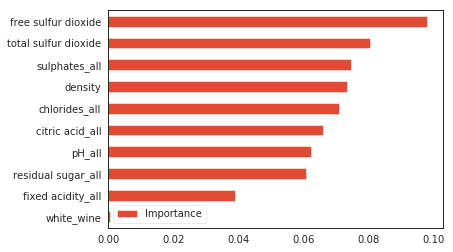

In [17]:
plot_variable_importance(X_train, y_train)

# 4. Моделирование 

## 4.1. Выбор модели 

В качестве модели выберем дерево решений. Параметры подберем с помощью кросс-валидации.

In [18]:
mdl_dt = DecisionTreeRegressor()
params_dt = {
    'max_depth': [4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_impurity_decrease':[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
}
mdl_dec_tree = GridSearchCV(mdl_dt, params_dt, scoring = 'r2', n_jobs = -1, cv = 5)

## 4.2. Подбор параметров, обеспечивающих наибольшую точность 

In [19]:
%%time
mdl_dec_tree.fit(X_train, y_train)
print(mdl_dec_tree.best_params_)

{'max_depth': 4, 'min_impurity_decrease': 0.03, 'min_samples_split': 2}
CPU times: user 19.2 s, sys: 799 ms, total: 20 s
Wall time: 1min 20s


### 4.3. Обучение модели 

In [21]:
mdl_dt = DecisionTreeRegressor(max_depth = 4, min_impurity_decrease = 0.03, min_samples_split = 2)
mdl_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, min_impurity_decrease=0.03)

# 5. Оценка

## 5.1. Оценка модели на обучающей и тестовой выборках

In [22]:
print('R^2: \t Обучающая выборка: {:.4f}. \t Тестовая выборка: {:.4f}'.format(
    r2_score(y_train, mdl_dt.predict(X_train)),
    r2_score(y_test, mdl_dt.predict(X_test))
))

R^2: 	 Обучающая выборка: 0.2162. 	 Тестовая выборка: 0.1782


# 6. Развертывание

Развертывание означает публикацию построенного дерева решений и составление рекомендаций для бизнеса на основе полученного дерева.

In [23]:
print(tree.export_graphviz(mdl_dt))

digraph Tree {
node [shape=box] ;
0 [label="X[11] <= 10.625\nmse = 0.765\nsamples = 4582\nvalue = 5.822"] ;
1 [label="X[2] <= 0.252\nmse = 0.538\nsamples = 2728\nvalue = 5.522"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="mse = 0.572\nsamples = 971\nvalue = 5.839"] ;
1 -> 2 ;
3 [label="mse = 0.434\nsamples = 1757\nvalue = 5.347"] ;
1 -> 3 ;
4 [label="mse = 0.772\nsamples = 1854\nvalue = 6.263"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
}
